# NYC Taxi Fare Prediction Project 
By.Mohamed Elshamy
## Project Overview
This project develops a machine learning model to predict taxi fares in New York City using various features including:
- Trip characteristics (distance, passengers)
- Location data (distances to landmarks)
- Temporal features (hour, weekday)
- Environmental conditions (weather, traffic)

## 1. Data Pipeline Setup
Importing necessary libraries for:
- Data manipulation (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Machine learning (sklearn, xgboost)
- Model deployment (streamlit)

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import pickle
import streamlit as st


## 2. Data Loading and Initial Exploration
Loading the dataset and performing initial examination of its structure and contents.

In [ ]:
df = pd.read_csv('final_internship_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

## 3. Data Preprocessing Pipeline
### 3.1 Feature Engineering Steps:
1. Column renaming for clarity
2. Missing value analysis
3. Distance feature normalization using PCA
4. Log transformation of numerical features
5. Categorical variable encoding

In [ ]:
# Rename columns for clarity
df.rename(columns={
    "jfk_dist": "jfk_airport_distance",
    "lga_dist": "lga_airport_distance",
    "ewr_dist": "ewr_airport_distance",
    "sol_dist": "statue_of_liberty_distance",
    "nyc_dist": "nyc_center_distance"
}, inplace=True)



df.columns[-25:]

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_airport_distance', 'ewr_airport_distance',
       'lga_airport_distance', 'statue_of_liberty_distance',
       'nyc_center_distance', 'distance', 'bearing'],
      dtype='object')

In [ ]:
# Check number and percentage of missing values in each column
missing_info = df.isnull().sum().to_frame(name='Missing Count')
missing_info['% Missing'] = 100 * missing_info['Missing Count'] / len(df)
missing_info = missing_info[missing_info['Missing Count'] > 0]  # show only columns with missing
missing_info.sort_values(by='Missing Count', ascending=False)


,Missing Count,% Missing
dropoff_longitude,5,0.001
dropoff_latitude,5,0.001
jfk_airport_distance,5,0.001
ewr_airport_distance,5,0.001
lga_airport_distance,5,0.001
statue_of_liberty_distance,5,0.001
nyc_center_distance,5,0.001
distance,5,0.001
bearing,5,0.001


In [ ]:
df.dropna(subset=['dropoff_longitude', 'dropoff_latitude', 'jfk_airport_distance', 'ewr_airport_distance', 'lga_airport_distance', 'statue_of_liberty_distance', 'nyc_center_distance', 'distance', 'bearing'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499995 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User ID                     499995 non-null  object 
 1   User Name                   499995 non-null  object 
 2   Driver Name                 499995 non-null  object 
 3   Car Condition               499995 non-null  object 
 4   Weather                     499995 non-null  object 
 5   Traffic Condition           499995 non-null  object 
 6   key                         499995 non-null  object 
 7   fare_amount                 499995 non-null  float64
 8   pickup_datetime             499995 non-null  object 
 9   pickup_longitude            499995 non-null  float64
 10  pickup_latitude             499995 non-null  float64
 11  dropoff_longitude           499995 non-null  float64
 12  dropoff_latitude            499995 non-null  float64
 13  passenger_count    

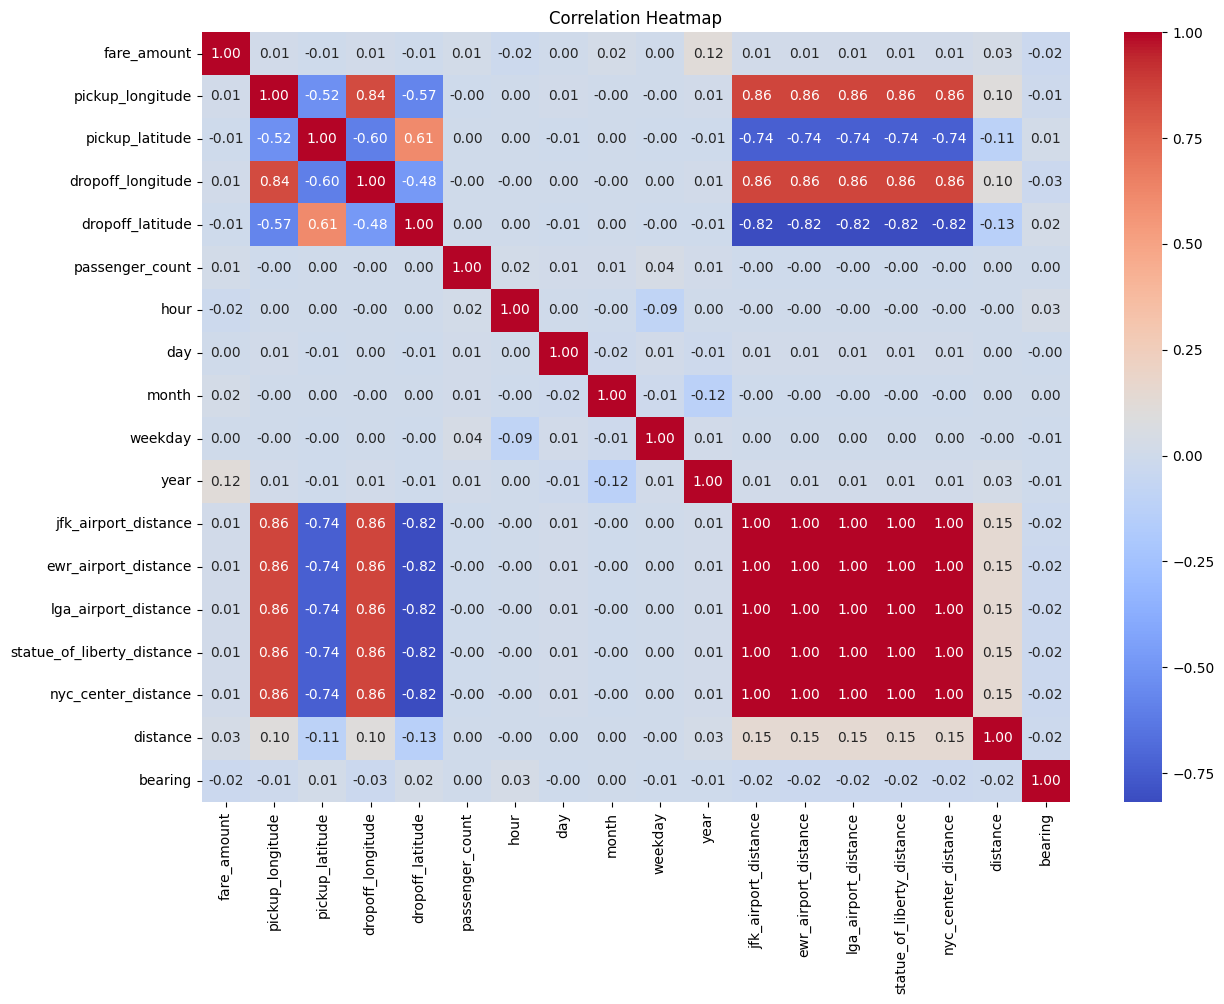

In [ ]:
# Correlation Heatmap
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(14, 10))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## 4. Feature Engineering
### 4.1 Landmark Distance Processing
Using PCA to combine multiple distance features into a single representative feature

In [ ]:
cols = ['jfk_airport_distance', 'ewr_airport_distance', 'lga_airport_distance',
        'nyc_center_distance', 'statue_of_liberty_distance']
# Normalize the data
X_landmarks = df[cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_landmarks)
df.dropna(inplace=True)

# Apply PCA (1 or 2 components usually enough)
pca = PCA(n_components=1)
df['landmark_distance_pca'] = pca.fit_transform(X_scaled)

# Drop original features
df.drop(columns=cols, inplace=True)
df.head()



,User ID,User Name,Driver Name,Car Condition,Weather,Traffic Condition,key,fare_amount,pickup_datetime,pickup_longitude,...,dropoff_latitude,passenger_count,hour,day,month,weekday,year,distance,bearing,landmark_distance_pca
0,KHVrEVlD,Kimberly Adams,Amy Butler,Very Good,windy,Congested Traffic,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-1.288826,...,0.710563,1,17,15,6,0,2009,1.030764,-2.918897,-0.312922
1,lPxIuEri,Justin Tapia,Hannah Zimmerman,Excellent,cloudy,Flow Traffic,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-1.291824,...,0.711780,1,16,5,1,1,2010,8.450134,-0.375217,-0.318129
2,gsVN8JLS,Elizabeth Lopez,Amanda Jackson,Bad,stormy,Congested Traffic,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-1.291242,...,0.711231,2,0,18,8,3,2011,1.389525,2.599961,-0.317904
3,9I7kWFgd,Steven Wilson,Amy Horn,Very Good,stormy,Flow Traffic,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-1.291319,...,0.711363,1,4,21,4,5,2012,2.799270,0.133905,-0.318832
4,8QN5ZaGN,Alexander Andrews,Cassandra Larson,Bad,stormy,Congested Traffic,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-1.290987,...,0.711811,1,7,9,3,1,2010,1.999157,-0.502703,-0.315595


## 5. Data Cleaning and Transformation
### 5.1 Handling Invalid Values
- Removing zero/negative values
- Setting reasonable value ranges
- Log transformation for fare and distance

In [ ]:

print("Zero or Negative Value Counts:\n")

for col in ['fare_amount', 'passenger_count', 'distance']:
    count = df[df[col] <= 0].shape[0]
    print(f"{col}: {count} rows")



Zero or Negative Value Counts:

fare_amount: 35 rows
passenger_count: 1791 rows
distance: 14250 rows


In [ ]:
# Remove rows with zero or negative values in key columns
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0) & (df['distance'] > 0)]

df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 300)]  # $300 max reasonable
df = df[(df['distance'] > 0) & (df['distance'] < 10)]        # 10 km max reasonable

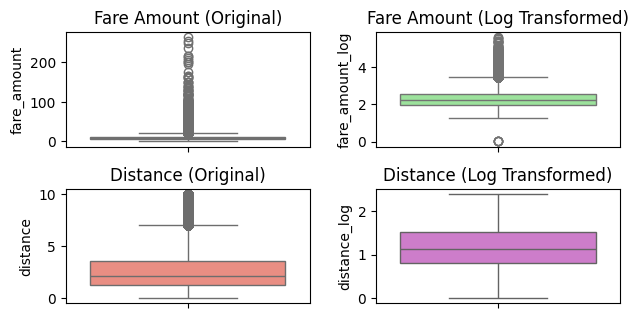

In [ ]:
df['fare_amount_log'] = np.log1p(df['fare_amount'])
df['distance_log'] = np.log1p(df['distance'])

# Before
# Fare Amount
plt.subplot(3, 2, 1)
sns.boxplot(y=df['fare_amount'], color="skyblue")
plt.title("Fare Amount (Original)")

plt.subplot(3, 2, 2)
sns.boxplot(y=df['fare_amount_log'], color="lightgreen")
plt.title("Fare Amount (Log Transformed)")

# Distance
plt.subplot(3, 2, 3)
sns.boxplot(y=df['distance'], color="salmon")
plt.title("Distance (Original)")

plt.subplot(3, 2, 4)
sns.boxplot(y=df['distance_log'], color="orchid")
plt.title("Distance (Log Transformed)")

plt.tight_layout()
plt.show()

In [ ]:
cat_cols = ['Weather', 'Traffic Condition']

# Convert categorical columns to category dtype 
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)
car_condition_map = {
    "Bad": 0,
    "Good": 1,
    "Very Good": 2,
    "Excellent": 3
}
df_encoded['Car Condition'] = df_encoded['Car Condition'].map(car_condition_map)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458137 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   User ID                              458137 non-null  object 
 1   User Name                            458137 non-null  object 
 2   Driver Name                          458137 non-null  object 
 3   Car Condition                        458137 non-null  int64  
 4   key                                  458137 non-null  object 
 5   fare_amount                          458137 non-null  float64
 6   pickup_datetime                      458137 non-null  object 
 7   pickup_longitude                     458137 non-null  float64
 8   pickup_latitude                      458137 non-null  float64
 9   dropoff_longitude                    458137 non-null  float64
 10  dropoff_latitude                     458137 non-null  float64
 11  passenger_count   

In [ ]:
df_encoded.drop(columns=[
    "User ID", "key", "User Name", "Driver Name", "pickup_datetime", "day", "month", "year", "dropoff_latitude",
    "dropoff_longitude", "pickup_latitude", "pickup_longitude" , "fare_amount" , "distance"
], inplace=True)


df_encoded.columns[-30:]

Index(['Car Condition', 'passenger_count', 'hour', 'weekday', 'bearing',
       'landmark_distance_pca', 'fare_amount_log', 'distance_log',
       'Weather_cloudy', 'Weather_rainy', 'Weather_stormy', 'Weather_sunny',
       'Weather_windy', 'Traffic Condition_Congested Traffic',
       'Traffic Condition_Dense Traffic', 'Traffic Condition_Flow Traffic'],
      dtype='object')

## Data Split

In [ ]:
# Prepare the data for modeling
y = df_encoded['fare_amount_log']
X = df_encoded.drop(columns=['fare_amount_log'])


# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Check the shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (366509, 15)
Test shape: (91628, 15)


## 6. Model Development Pipeline
### 6.1 Model Selection Process:
1. Linear Regression (baseline)
2. Random Forest
3. Gradient Boosting
4. XGBoost (best performing)

In [ ]:

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Model: {name}")
    print(f"Train - R2: {train_r2:.4f} | RMSE: {train_rmse:.4f} | MSE: {train_mse:.4f} | MAE: {train_mae:.4f}")
    print(f"Test  - R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MSE: {test_mse:.4f} | MAE: {test_mae:.4f}")
    print("-" * 50)

Model: Linear Regression
Train - R2: 0.6685 | RMSE: 0.2625 | MSE: 0.0689 | MAE: 0.1789
Test  - R2: 0.6708 | RMSE: 0.2615 | MSE: 0.0684 | MAE: 0.1788
--------------------------------------------------
Model: Random Forest
Train - R2: 0.9650 | RMSE: 0.0852 | MSE: 0.0073 | MAE: 0.0575
Test  - R2: 0.7490 | RMSE: 0.2283 | MSE: 0.0521 | MAE: 0.1542
--------------------------------------------------
Model: Gradient Boosting
Train - R2: 0.7524 | RMSE: 0.2268 | MSE: 0.0515 | MAE: 0.1549
Test  - R2: 0.7481 | RMSE: 0.2287 | MSE: 0.0523 | MAE: 0.1555
--------------------------------------------------
Model: XGBoost
Train - R2: 0.7889 | RMSE: 0.2095 | MSE: 0.0439 | MAE: 0.1443
Test  - R2: 0.7571 | RMSE: 0.2246 | MSE: 0.0504 | MAE: 0.1490
--------------------------------------------------


## 7. Model Tuning
Hyperparameter optimization for XGBoost using RandomizedSearchCV

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor()
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best parameters:", search.best_params_)
print("Best CV score (R2):", search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV score (R2): 0.7595970018075894


In [ ]:
best_model = search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f" Mean Squared Error (MSE): {mse:.4f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f" Mean Absolute Error (MAE): {mae:.4f}")
print(f" R² Score: {r2:.4f}")

 Mean Squared Error (MSE): 0.0498
 Root Mean Squared Error (RMSE): 0.2231
 Mean Absolute Error (MAE): 0.1489
 R² Score: 0.7603


## 8. Model Deployment
### 8.1 Streamlit Web Application
Creating an interactive web interface for real-time predictions

In [ ]:
pickle.dump(best_model, open("model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(pca, open("pca.pkl", "wb"))